In [1]:
import os
import sys

sys.path.extend([
    "C:\\Users\\Wyss User\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages",
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\src",
])

from identify_targets import identify_targets
from raw_data_preprocessing import clean_up_raw_data
from raw_data_preprocessing import plot_protein_fractionation

os.chdir("C:\\Users\\Wyss User\\Documents\\EVs\\OLINK")

In [2]:
assay_list_path = "data\\231220_ht_panel_assay_list.xlsx"
brain_rna_seq_raw_path = "data\\240411_brain_rna_seq_raw.csv"
output_directory = "outputs\\ht_output"
plate_layout_path = "data\\231204_Walt_Olink_HT_Plate.xlsx"
raw_data = "data\\240214_Walt_Olink_HT_Raw.parquet"
uniprot_fasta_database = "data\\uniprot_fasta_database.gz"

In [3]:
# create a tidy dataframe from the raw data file

tidy_data = clean_up_raw_data(raw_data, plate_layout_path)

C:\Users\Wyss User\Documents\EVs\OLINK\src\raw_data_preprocessing.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_data["Delta"] = unique_data.apply(
C:\Users\Wyss User\Documents\EVs\OLINK\src\raw_data_preprocessing.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_data.loc[:, "Linear NPX"] = unique_data["PCNormalizedNPX"].map(lambda x: 2**x)


In [4]:
# identify targets found inside microglia cells that may be EV associated

identify_targets(
    assay_list_path = assay_list_path,
    uniprot_fasta_database = uniprot_fasta_database, 
    brain_rna_seq_raw_path = brain_rna_seq_raw_path,
    region = "internal", 
    cell_type = "microglia", 
    specificity_metric = "tau", 
    specificity_cutoff = 0.75,
    high_fractions = ['9', '10'], 
    low_fractions = ['7', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    raw_olink_data_file = raw_data,
    plate_layout_dataframe = plate_layout_path,
    output_directory = output_directory
    )

C:\Users\Wyss User\Documents\EVs\OLINK\src\raw_data_preprocessing.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_data["Delta"] = unique_data.apply(
C:\Users\Wyss User\Documents\EVs\OLINK\src\raw_data_preprocessing.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_data.loc[:, "Linear NPX"] = unique_data["PCNormalizedNPX"].map(lambda x: 2**x)


{'A2A288',
 'P14317',
 'P19838',
 'P57796',
 'Q12802',
 'Q6P0N0',
 'Q6P589',
 'Q7Z6K4',
 'Q9NP95',
 'Q9Y572'}

In [5]:
# identify targets found inside microglia cells that may be EV associated

identify_targets(
    assay_list_path = assay_list_path,
    uniprot_fasta_database = uniprot_fasta_database, 
    brain_rna_seq_raw_path = brain_rna_seq_raw_path,
    region = "internal", 
    cell_type = "microglia", 
    specificity_metric = "tau", 
    specificity_cutoff = 0.75,
    high_fractions = ['9', '10'], 
    low_fractions = ['7', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    plate_layout_dataframe = plate_layout_path,
    tidy_dataframe = tidy_data,
    output_directory = output_directory
    )

{'A2A288',
 'P14317',
 'P19838',
 'P57796',
 'Q12802',
 'Q6P0N0',
 'Q6P589',
 'Q7Z6K4',
 'Q9NP95',
 'Q9Y572'}

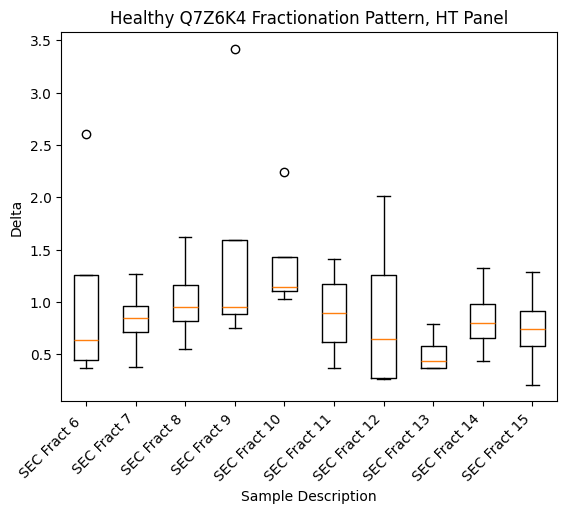

In [8]:
# make a box-and-whisker plot for a target of interest

plot_protein_fractionation(tidy_data, "Q7Z6K4")